# 노트북에서 예측 모델 학습하기

In [1]:
import torch 
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cpu')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train on GPU.")
else:
    print("No cuda available")

No cuda available


## 데이터세트 다운로드

In [3]:
! wget https://objectstorage.kr-central-2.kakaocloud.com/v1/252267c6b6f745eba8b850ec047b673e/kbm-files/guide_docs/hands_on/nyc_taxi_fare/data/train.csv -O train.csv

--2024-09-25 10:16:16--  https://objectstorage.kr-central-2.kakaocloud.com/v1/252267c6b6f745eba8b850ec047b673e/kbm-files/guide_docs/hands_on/nyc_taxi_fare/data/train.csv
Resolving objectstorage.kr-central-2.kakaocloud.com (objectstorage.kr-central-2.kakaocloud.com)... 61.109.235.79
Connecting to objectstorage.kr-central-2.kakaocloud.com (objectstorage.kr-central-2.kakaocloud.com)|61.109.235.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105778213 (101M) [text/csv]
Saving to: ‘train.csv’

train.csv           100%[===================>] 100.88M   342MB/s    in 0.3s    

2024-09-25 10:16:17 (342 MB/s) - ‘train.csv’ saved [105778213/105778213]



In [4]:
df = pd.read_csv("train.csv", index_col=False)
print(df)

                                  key  fare_amount          pickup_datetime  \
0         2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1         2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2        2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3         2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4       2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   
...                               ...          ...                      ...   
999995    2014-09-13 21:44:38.0000001          7.0  2014-09-13 21:44:38 UTC   
999996    2010-09-20 14:50:37.0000002          7.3  2010-09-20 14:50:37 UTC   
999997  2013-04-26 14:03:00.000000118         10.5  2013-04-26 14:03:00 UTC   
999998   2011-07-08 00:29:00.00000099          6.9  2011-07-08 00:29:00 UTC   
999999   2009-12-31 14:30:00.00000021          4.1  2009-12-31 14:30:00 UTC   

        pickup_longitude  pickup_latitude  dropoff_

In [5]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


## 데이터 전처리

In [6]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])  # converting the longitude and latidtude into numpy radians
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [7]:
df['distance_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude','dropoff_latitude','dropoff_longitude')

In [8]:
df.drop(columns=['key'], inplace=True, errors='ignore')
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157
...,...,...,...,...,...,...,...,...
999995,7.0,2014-09-13 21:44:38 UTC,-73.976676,40.785630,-73.959196,40.775114,1,1.879763
999996,7.3,2010-09-20 14:50:37 UTC,-73.992103,40.671385,-73.992103,40.671385,2,0.000000
999997,10.5,2013-04-26 14:03:00 UTC,-73.978423,40.751135,-73.993397,40.762197,5,1.761741
999998,6.9,2011-07-08 00:29:00 UTC,-73.980317,40.759482,-73.976832,40.743122,1,1.842683


In [9]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   fare_amount        1000000 non-null  float64            
 1   pickup_datetime    1000000 non-null  datetime64[ns, UTC]
 2   pickup_longitude   1000000 non-null  float64            
 3   pickup_latitude    1000000 non-null  float64            
 4   dropoff_longitude  999990 non-null   float64            
 5   dropoff_latitude   999990 non-null   float64            
 6   passenger_count    1000000 non-null  int64              
 7   distance_km        999990 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 61.0 MB


In [11]:
df['edtdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [12]:
df['Hour'] = df['edtdate'].dt.hour
df['am_or_pm'] = np.where(df['Hour']<12, 'am', 'pm')
df['weekday'] = df['edtdate'].dt.strftime("%a")

In [13]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,edtdate,Hour,am_or_pm,weekday
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,2009-06-15 13:26:21+00:00,13,pm,Mon
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,2010-01-05 12:52:16+00:00,12,pm,Tue
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,2011-08-17 20:35:00+00:00,20,pm,Wed
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2012-04-21 00:30:42+00:00,0,am,Sat
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,2010-03-09 03:51:00+00:00,3,am,Tue


In [14]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'distance_km', 'edtdate', 'Hour', 'am_or_pm', 'weekday'],
      dtype='object')

In [15]:
cat_cols = ['Hour', 'am_or_pm', 'weekday']
cont_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance_km']

In [16]:
y_col = ['fare_amount']

In [17]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [18]:
df.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
distance_km                      float64
edtdate              datetime64[ns, UTC]
Hour                            category
am_or_pm                        category
weekday                         category
dtype: object

In [19]:
hr = df['Hour'].cat.codes.values
am_pm = df['am_or_pm'].cat.codes.values
wkdy = df['weekday'].cat.codes.values

In [20]:
cats = np.stack([hr,am_pm,wkdy], axis=1)
cats

array([[13,  1,  1],
       [12,  1,  5],
       [20,  1,  6],
       ...,
       [10,  0,  0],
       [20,  1,  4],
       [10,  0,  4]], dtype=int8)

In [21]:
cats = torch.tensor(cats, dtype=torch.int64)

In [22]:
conts = np.stack([df[col].values for col in cont_cols], axis=1)

In [23]:
conts

array([[-73.844311  ,  40.721319  , -73.84161   ,  40.712278  ,
          1.        ,   1.03076394],
       [-74.016048  ,  40.711303  , -73.979268  ,  40.782004  ,
          1.        ,   8.4501336 ],
       [-73.982738  ,  40.76127   , -73.991242  ,  40.750562  ,
          2.        ,   1.38952523],
       ...,
       [-73.978423  ,  40.751135  , -73.993397  ,  40.762197  ,
          5.        ,   1.76174086],
       [-73.980317  ,  40.759482  , -73.976832  ,  40.743122  ,
          1.        ,   1.84268322],
       [-74.006635  ,  40.741598  , -73.99945   ,  40.745702  ,
          1.        ,   0.75805146]])

In [24]:
### Converting it into tensors
conts = torch.tensor(conts, dtype=torch.float)
conts

tensor([[-73.8443,  40.7213, -73.8416,  40.7123,   1.0000,   1.0308],
        [-74.0160,  40.7113, -73.9793,  40.7820,   1.0000,   8.4501],
        [-73.9827,  40.7613, -73.9912,  40.7506,   2.0000,   1.3895],
        ...,
        [-73.9784,  40.7511, -73.9934,  40.7622,   5.0000,   1.7617],
        [-73.9803,  40.7595, -73.9768,  40.7431,   1.0000,   1.8427],
        [-74.0066,  40.7416, -73.9995,  40.7457,   1.0000,   0.7581]])

In [25]:
conts.shape

torch.Size([1000000, 6])

In [26]:
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)
y.shape

torch.Size([1000000, 1])

In [27]:
cat_sizes = [len(df[col].cat.categories) for col in cat_cols]
cat_sizes

[24, 2, 7]

In [28]:
emb_sizes = [(size, min(50,(size+1)//2)) for size in cat_sizes]
emb_sizes

[(24, 12), (2, 1), (7, 4)]

In [29]:
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_sizes])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

## 예측 모델 학습

In [30]:
class TabularModel(nn.Module):
    
    def __init__(self, emb_sizes, n_cont, out_szs, layers, p=0.5):
        super().__init__()
        
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layer_list = []
        n_emb = sum([nf for ni,nf in emb_sizes])
        n_in = n_emb + n_cont
        
        for i in layers:
            layer_list.append(nn.Linear(n_in, i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            n_in = i
            
        layer_list.append(nn.Linear(layers[-1], out_szs))
        
        self.layers = nn.Sequential(*layer_list)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
            
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont], 1)
        x = self.layers(x)
        
        return x

In [31]:
torch.manual_seed(33)
model = TabularModel(emb_sizes, conts.shape[1], 1,[200,100], p=0.4)

In [32]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [33]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [34]:
batch_size=60000
test_size = int(batch_size*0.2)

In [35]:
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

In [36]:
y_train=y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [37]:
len(cat_train)

48000

In [38]:
len(con_train)

48000

In [39]:
import time

start_time = time.time()

final_losses = []

for epochs in range(100):
    optimizer.zero_grad()
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    final_losses.append(loss)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epochs+1}, loss: {loss.item()}")
    
duration = time.time() - start_time
print(f"Training took {duration/60} minutes")

Epoch 1, loss: 14.989654541015625
Epoch 2, loss: 14.966270446777344
Epoch 3, loss: 14.899831771850586
Epoch 4, loss: 14.865638732910156
Epoch 5, loss: 14.827088356018066
Epoch 6, loss: 14.772923469543457
Epoch 7, loss: 14.706470489501953
Epoch 8, loss: 14.624122619628906
Epoch 9, loss: 14.527762413024902
Epoch 10, loss: 14.421438217163086
Epoch 11, loss: 14.304932594299316
Epoch 12, loss: 14.157746315002441
Epoch 13, loss: 14.019085884094238
Epoch 14, loss: 13.839574813842773
Epoch 15, loss: 13.653108596801758
Epoch 16, loss: 13.470829963684082
Epoch 17, loss: 13.246794700622559
Epoch 18, loss: 13.022604942321777
Epoch 19, loss: 12.78430461883545
Epoch 20, loss: 12.527644157409668
Epoch 21, loss: 12.267768859863281
Epoch 22, loss: 11.99387264251709
Epoch 23, loss: 11.723966598510742
Epoch 24, loss: 11.45756721496582
Epoch 25, loss: 11.18661880493164
Epoch 26, loss: 10.928346633911133
Epoch 27, loss: 10.695672988891602
Epoch 28, loss: 10.478654861450195
Epoch 29, loss: 10.28960704803466

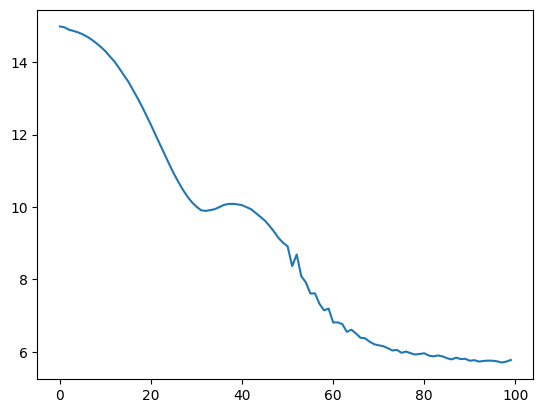

In [40]:
### PLotting the loss function
visualize_losses = [_ea_tensor.detach().numpy() for _ea_tensor in final_losses]

# 에러 발생시 아래의 주석을 해제하여 matplotlib를 재설치 해주세요.
# !pip install matplotlib==3.8.2
plt.plot(range(100), visualize_losses)

## 테스트 데이터세트 검증

In [42]:
### Evaluating our model on the test set
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))

In [43]:
for i in range(20):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'예측값 : {y_val[i].item():8.4f} 실측값 : {y_test[i].item():8.2f} 절대오차 : {diff:8.2f}')

예측값 :  11.8898 실측값 :    12.00 절대오차 :     0.11
예측값 :  11.6485 실측값 :    15.30 절대오차 :     3.65
예측값 :  13.1570 실측값 :    14.50 절대오차 :     1.34
예측값 :  19.6059 실측값 :    18.00 절대오차 :     1.61
예측값 :  23.1862 실측값 :    24.00 절대오차 :     0.81
예측값 :  10.2114 실측값 :     9.70 절대오차 :     0.51
예측값 :  10.7716 실측값 :    11.00 절대오차 :     0.23
예측값 :  28.7731 실측값 :    26.00 절대오차 :     2.77
예측값 :   5.2272 실측값 :     5.00 절대오차 :     0.23
예측값 :   5.1038 실측값 :    13.00 절대오차 :     7.90
예측값 :  50.9428 실측값 :    49.15 절대오차 :     1.79
예측값 :   5.7370 실측값 :     8.90 절대오차 :     3.16
예측값 :   6.2946 실측값 :     6.50 절대오차 :     0.21
예측값 :  11.9370 실측값 :    13.00 절대오차 :     1.06
예측값 :  10.8880 실측값 :    17.00 절대오차 :     6.11
예측값 :   5.9029 실측값 :     6.10 절대오차 :     0.20
예측값 :   7.5005 실측값 :    12.10 절대오차 :     4.60
예측값 :  21.0924 실측값 :    17.50 절대오차 :     3.59
예측값 :   7.5162 실측값 :     6.50 절대오차 :     1.02
예측값 :   6.9482 실측값 :    10.00 절대오차 :     3.05
